In [1]:
%matplotlib notebook
from scipy.io import loadmat
import numpy as np
import pandas as pd
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import itertools
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.linear_model import LinearRegression


In [2]:
dat = loadmat('../data/corr/wbdata/TS20141221b_THK178_lite-1_punc-31_NLS3_6eggs_1mMTet_basal_1080s.mat')

# Parse the heinous .mat Ca data

Inside we'll find some calcium imaging data.

In [3]:
# load and clean data
dfof = dat['wbData']['deltaFOverF'][0][0]

# ids are in an atrocious state, just want a damn list sometimes yano
ids = dat['wbData']['NeuronIds'][0][0][0]
id_list = []
for id in ids:
    sub_id = id[0].tolist()
    try:
        subsub_id = sub_id[0].tolist()
        id_list.append(subsub_id)
    except IndexError:
        id_list.append([""])
        
ids = np.array([subitem for sublist in id_list for subitem in sublist])


Only some of the cells were identified, so we subset to those.

In [4]:
id_idx = np.where(ids)[0]
ids = ids[id_idx]
dfof = dfof[:,id_idx]

# rearrange in alphabetical order so our correlation matrices match up
dfof = dfof[:,np.argsort(ids)]

Do the correlation

In [5]:
# tada!
dfof_corr = np.corrcoef(dfof.T)

# Load that connectome!

In [6]:
# load the connectome
connect = pd.read_excel('../data/corr/CElegansNeuronTables.xls')

# subset only the cells we have in the Ca data
good_cells = np.logical_and(connect['Origin'].isin(ids), connect['Target'].isin(ids))
connect = connect.loc[good_cells,:]

# a weight column
connect['w'] = np.zeros(connect.shape[0])

Surprise surprise, most cells aren't connected. We will the connectome with zero-weighted 

In [7]:
# make sure we have all the same cells 
pair_list = list(itertools.permutations(sorted(ids),2))
for pair in pair_list:
    # if the pair isn't in the dframe...
    if connect[np.logical_and(connect['Origin'] == pair[0], connect['Target'] == pair[1])].shape[0] == 0:
        # add an 'unconnected row'
        connect = connect.append({'Origin': pair[0],
                                  'Target': pair[1],
                                  'Type': 'Unconnected',
                                  'Number of Connections':0,
                                  'Neurotransmitter': "None",
                                  'w':0}, ignore_index=True)
        
# sort this too
connect.sort_values(by=['Origin', 'Target'], axis=0, inplace=True)

Make a connectivity matrix. I'm doing this pretty naively -- there are lots of different neurotransmitters in c. elegans neurons, but if correlation is a proxy for connectivity, *any* type of connectivity (inhibitory, excitatory, etc.) should induce correlation, we just have to take the absolute value.

In [8]:
naive = copy(connect)

# Set all the points that aren't "unconnected" to 1
naive.loc[naive['Type'] != "Unconnected",'w'] = 1.0

# multiply by the number of connections to get a very rough estimate of connection strength.
naive.loc[:,'w'] = naive.loc[:,'w']*naive.loc[:,'Number of Connections']



In [9]:
# collapse duplicates - some synapses are listed twice because they have both gap junctions and chemical synapses.
naive_sum = naive.groupby(["Origin", "Target"])['w'].sum()
naive_sum = naive_sum.reset_index()

# rescale to 0-1
naive_sum.loc[:,'w'] = naive_sum.w/(naive_sum.w.max())

# pivot to an adjacency matrix
# pivoting automatically sorts by 
naive_adj = naive_sum.pivot(index="Origin", columns="Target", values='w')
naive_adj.fillna(value=0, inplace=True)

# Plot the results...

First, let's just compare the two matrices

<IPython.core.display.Javascript object>


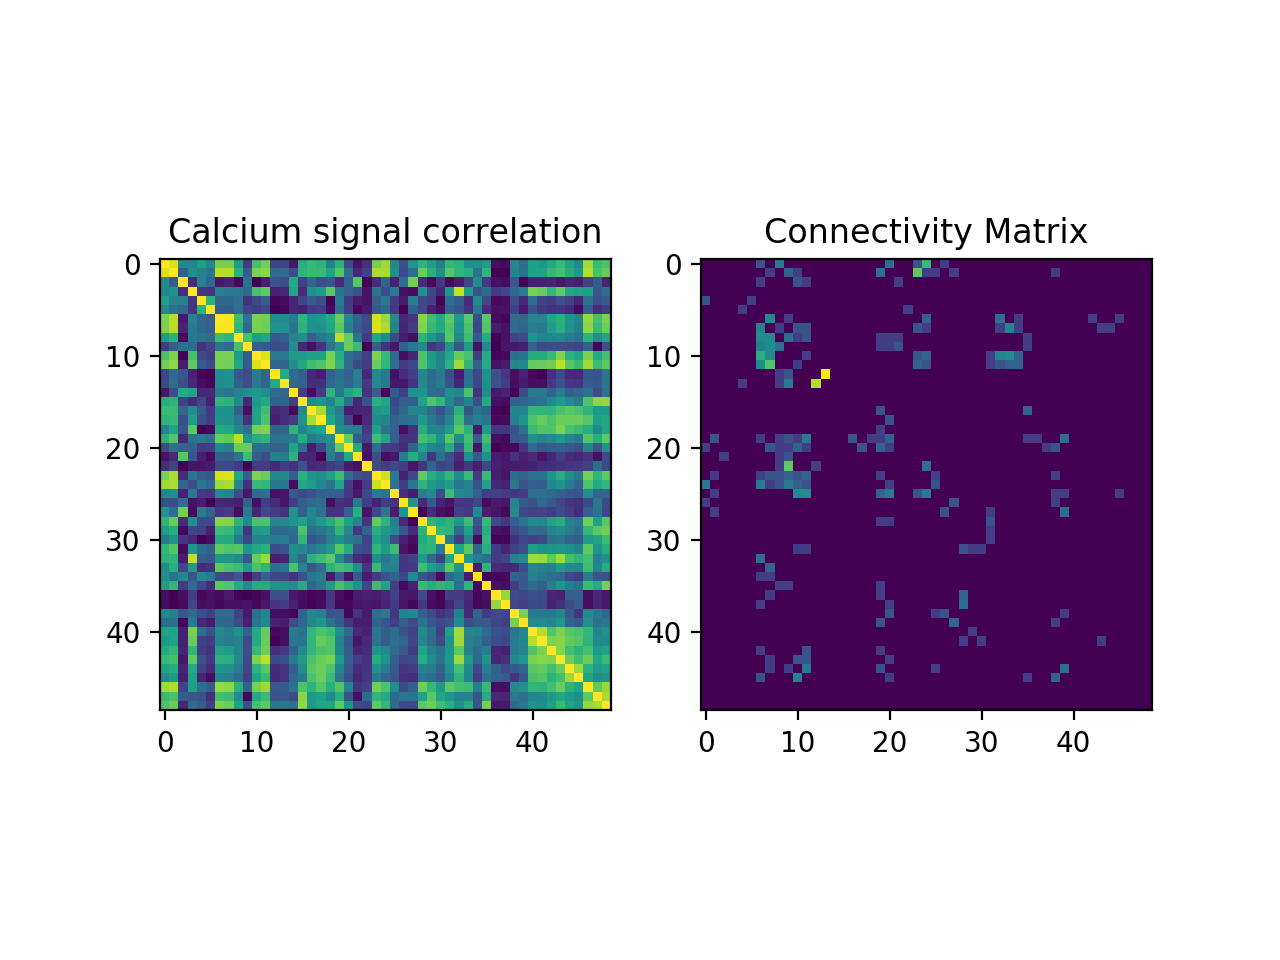

Text(0.5,1,'Connectivity Matrix')

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(dfof_corr))
ax[1].imshow(np.sqrt(naive_adj.values))

ax[0].set_title('Calcium signal correlation')
ax[1].set_title('Connectivity Matrix')

It doesn't look like there's much overlap -- this makes clear one of the really obvious problems with "functional connectivity" -- most neurons are not connected to one another, but most timeseries will have some nonzero correlation. Though if there is some magic that happens when you group millions of neurons together that suddenly makes them connected to every other neuron, I'd like to hear about it.

How about a really ugly scatterplot? (h8 me, i need to get to work)

<IPython.core.display.Javascript object>


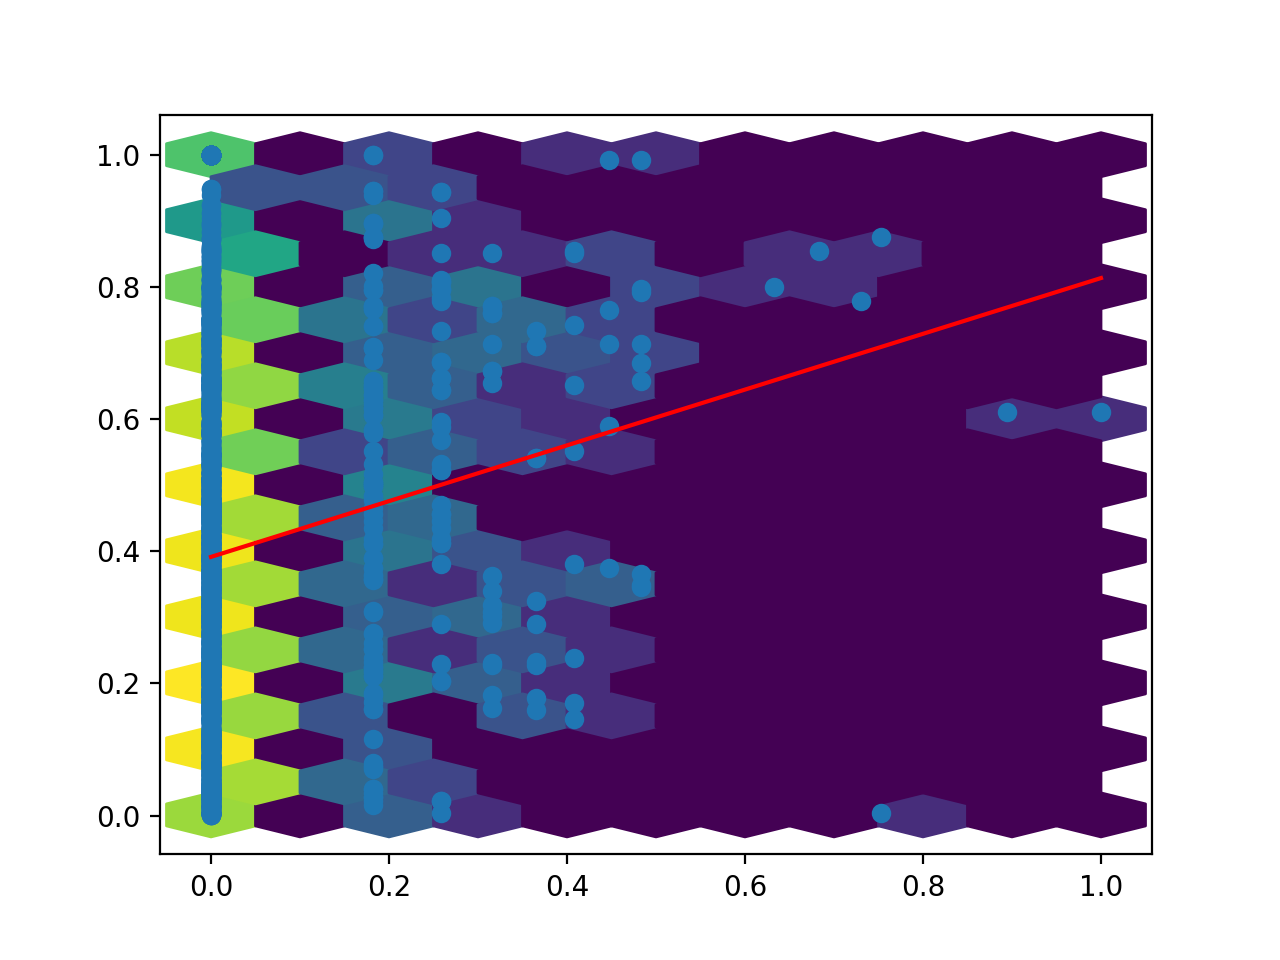

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [11]:
fig, ax = plt.subplots()

# use the square root because there are very few connections with the highest strength and most are zero...
# hey gotta transform somehow.
sqrt_connectivity = np.sqrt(naive_adj.values)

# do a lil linear regression
model = LinearRegression()
model.fit(sqrt_connectivity.reshape(-1,1), np.abs(dfof_corr).reshape(-1,1))

# make predicted points
x_new = np.linspace(0, 1, 100)
y_new = model.predict(x_new[:, np.newaxis])



# also log scale the fill because most points are unconnected.
ax.hexbin(sqrt_connectivity,np.abs(dfof_corr), 
          gridsize=(10,10),
          norm=colors.LogNorm())
ax.scatter(sqrt_connectivity,np.abs(dfof_corr))
ax.plot(x_new, y_new, color="r")


O snap that line slopes up, i wonder what the R^2 is?

In [12]:
model.score(sqrt_connectivity.reshape(-1,1), np.abs(dfof_corr).reshape(-1,1))

0.020443230361266274

Uh oh... how about an ROC just for good measure? We'll use boolean connectivity rather than the connection 'weight'

In [23]:
connect_bool = np.ndarray((np.ravel(naive_adj.values).shape),
                         dtype=np.bool)
connect_bool[np.where(np.ravel(naive_adj.values))] = True


fpr, tpr, thresholds = roc_curve(connect_bool,
                                 np.ravel(np.abs(dfof_corr)))

<IPython.core.display.Javascript object>


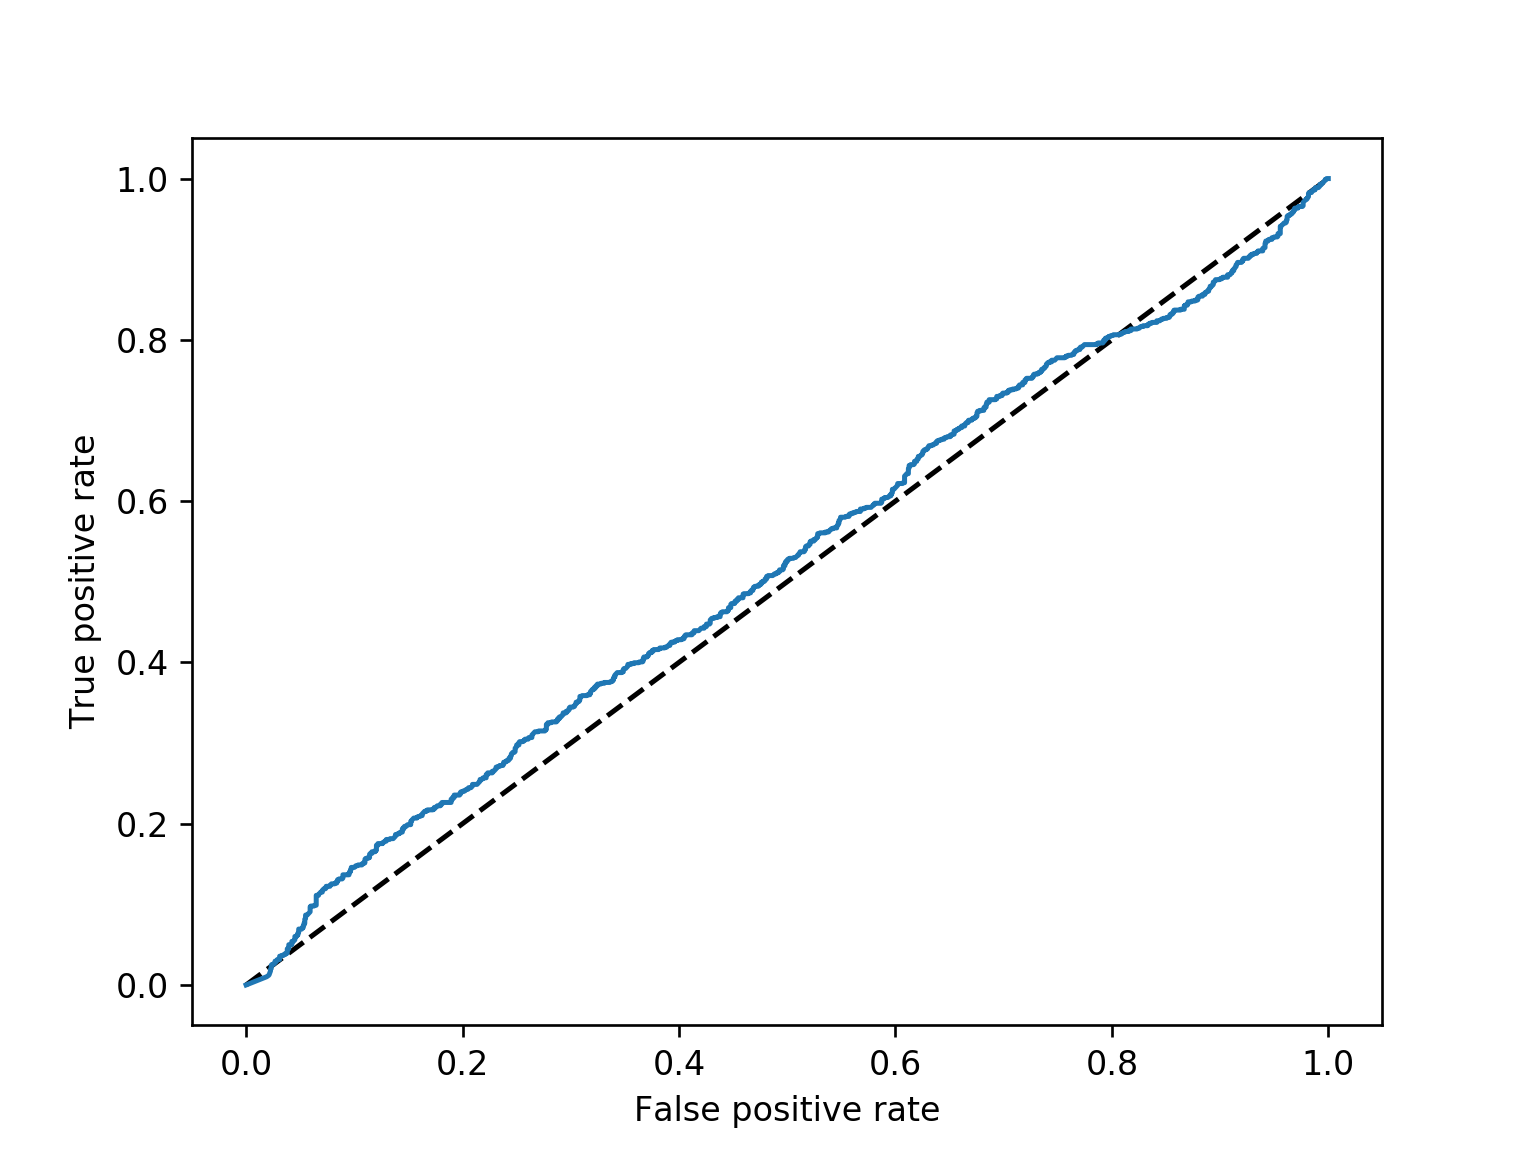

Text(0,0.5,'True positive rate')

In [24]:
fig, ax = plt.subplots()

ax.plot([0,1], [0,1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')


And the AUC?

In [15]:
roc_auc_score(connect_bool, np.ravel(np.abs(dfof_corr)))

0.5407500817336883

o no.